In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import libpysal as lp
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://raw.github.com/ssujit/move_sustainable/main/data/'

# variable declaration
wkam = 'wkamo_hdn.gpkg' # wkamo: weekdays peak-traffic morning hours (6:00-8:59) 
wkpm = 'wkpmo_hdn.gpkg' # wkpmo: weekdays peak-traffic afternoon hours (14:00-16:59) 
satam = 'satamo_hdn.gpkg' # satamo: Saturday peak-traffic morning hours (6:00-8:59) 
satpm = 'satpmo_hdn.gpkg' # satpmo: Saturday peak-traffic afternoon hours (14:00-16:59)  
sunam = 'sunamo_hdn.gpkg' # sunamo: Saturday peak-traffic morning hours (6:00-8:59)
sunpm = 'sunamo_hdn.gpkg' # sunpmo: Saturday peak-traffic afternoon hours (14:00-16:59) 

#read the files
wk_am = gpd.read_file(f'{url}{wkam}')
wk_pm = gpd.read_file(f'{url}{wkpm}')
sat_am = gpd.read_file(f'{url}{satam}')
sat_pm = gpd.read_file(f'{url}{satpm}')
sun_am = gpd.read_file(f'{url}{sunam}')
sun_pm = gpd.read_file(f'{url}{sunpm}')

In [3]:
sun_am.head()

,VALUE,grid_name,net_dis,perH_sum,pti,geometry
0,768.94497,2,769,4.33333,0.005635,"POLYGON ((354747.343 5672460.510, 355828.624 5..."
1,855.81989,3,856,0.66666,0.000779,"POLYGON ((355828.624 5672460.510, 356909.906 5..."
2,988.74922,4,989,NaN,NaN,"POLYGON ((356909.906 5672460.510, 357991.187 5..."
3,707.28729,5,707,2.00000,0.002828,"POLYGON ((353666.061 5671273.733, 354747.343 5..."
4,166.20974,6,166,10.66666,0.064176,"POLYGON ((354747.343 5671273.733, 355828.624 5..."


In [4]:
sun_am.explore()

<Axes: xlabel='pti', ylabel='Density'>

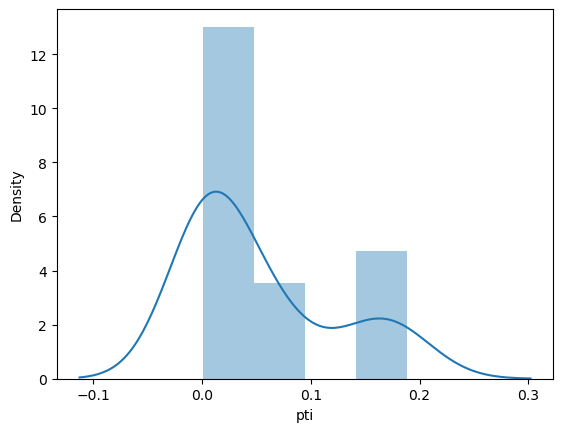

In [5]:
sns.distplot(sun_am['pti'])

<Axes: >

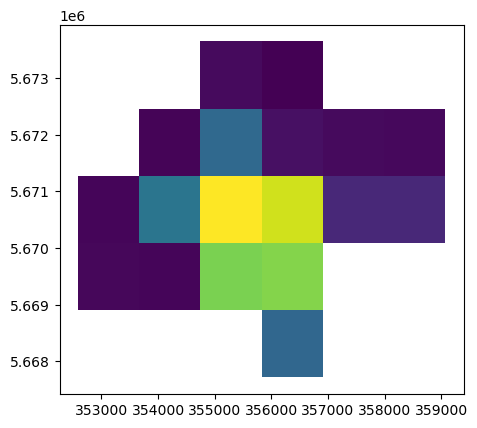

In [6]:
sun_am.plot("pti")

<Axes: >

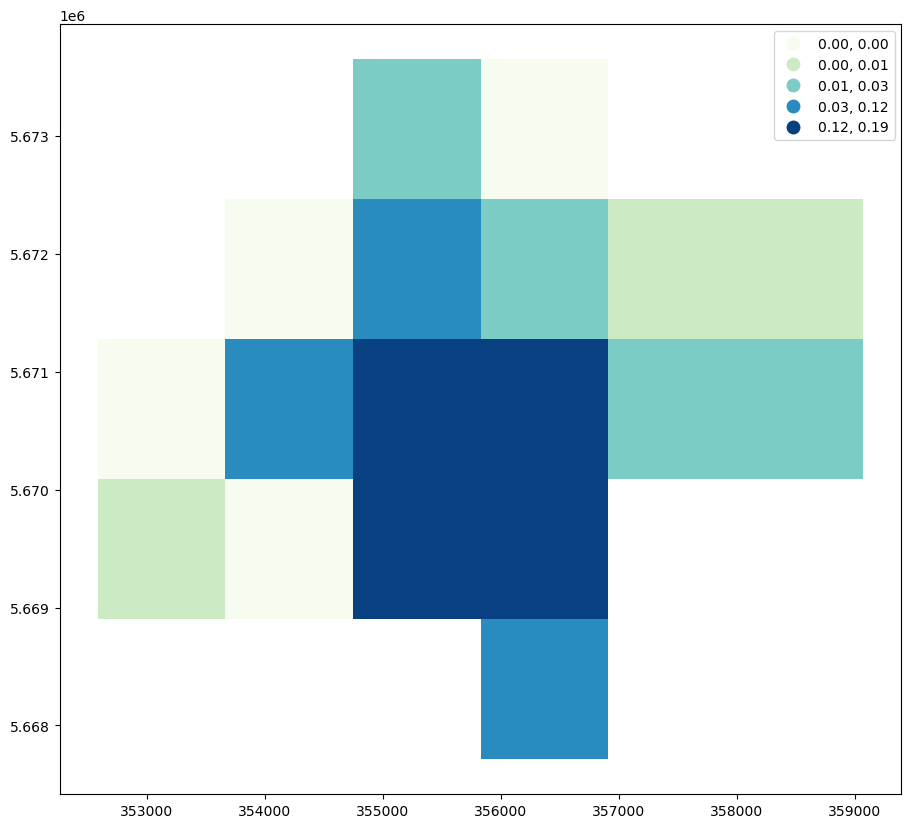

In [7]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
sun_am.plot(column='pti', scheme='Quantiles', 
        k=5, cmap='GnBu', legend=True, ax=ax)

In [8]:
wq =  lp.weights.Queen.from_dataframe(sun_am)
wq.transform = 'r'

In [9]:
y = sun_am['pti']
ylag = lp.weights.lag_spatial(wq, y)

In [10]:
ylag

array([0.01908334,        nan, 0.00502353, 0.06712196, 0.06506359,
              nan,        nan,        nan, 0.0210184 , 0.0596022 ,
       0.07914958,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.08719233,        nan,
              nan,        nan])

In [11]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

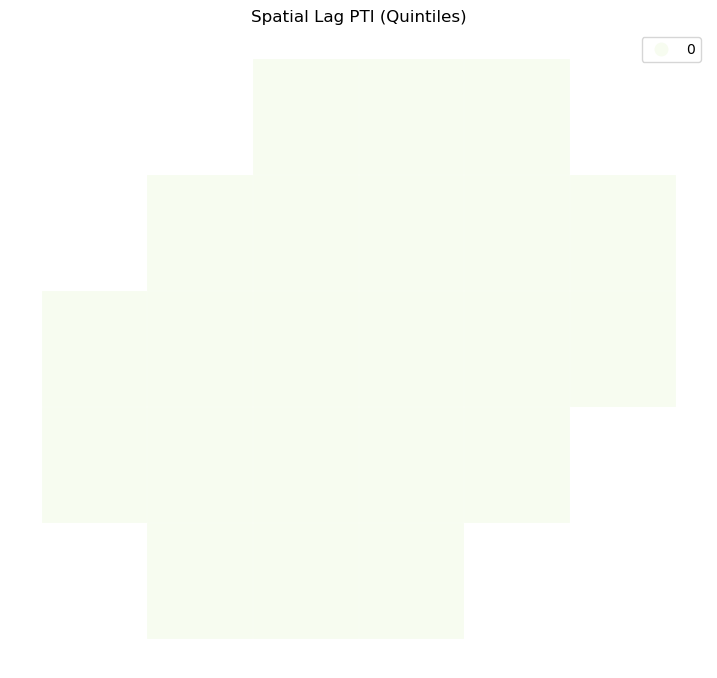

In [12]:
f,ax = plt.subplots(1, figsize=(9, 9), subplot_kw=dict(aspect='equal'))
sun_am.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,
        k=5, cmap='GnBu', linewidth=0.1,
        edgecolor='white', legend=True, ax=ax)
ax.set_axis_off()
plt.title("Spatial Lag PTI (Quintiles)")

plt.show()

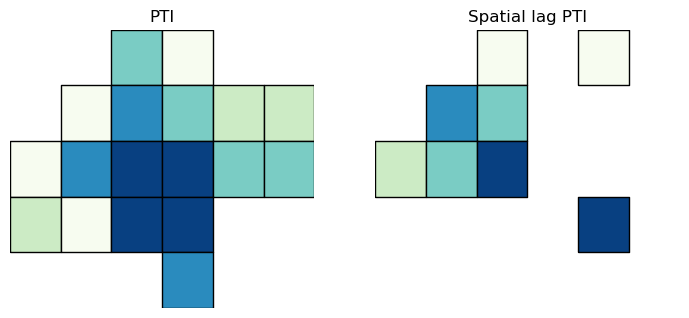

In [36]:
sun_am['lag_PTI'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4), subplot_kw=dict(aspect='equal'))
sun_am.plot(column='pti', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(sun_am.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("PTI")
sun_am.plot(column='lag_PTI', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(wk_am.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial lag PTI")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [14]:
y.median()

0.015056942104084559

In [15]:
yb = y > y.median()
sum(yb)

9

In [16]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
sun_am['yb'] = yb

<Axes: >

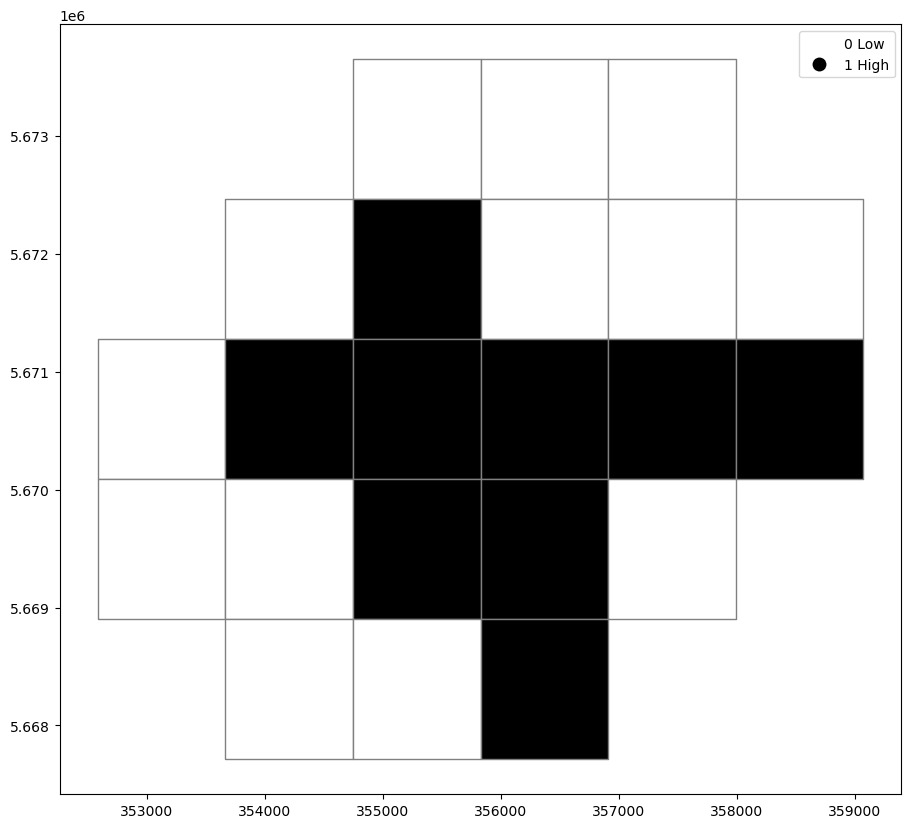

In [17]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
sun_am.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [18]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  lp.weights.Queen.from_dataframe(sun_am)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

In [19]:
jc.bb

16.0

In [20]:
jc.ww

19.0

In [21]:
jc.bw

28.0

In [22]:
jc.bb + jc.ww + jc.bw

63.0

In [23]:
wq.s0 / 2

63.0

In [24]:
jc.bb

16.0

In [25]:
jc.mean_bb

9.733733733733734

Text(0.5, 0, 'BB Counts')

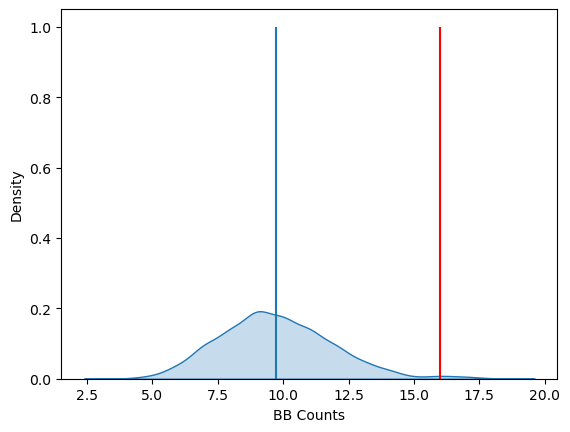

In [26]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 1, color='r')
plt.vlines(jc.mean_bb, 0,1)
plt.xlabel('BB Counts')

In [27]:
jc.p_sim_bb

0.017

In [28]:
wq.transform = 'r'

In [29]:
y = sun_am['pti']

In [30]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

nan

Text(0.5, 0, "Moran's I")

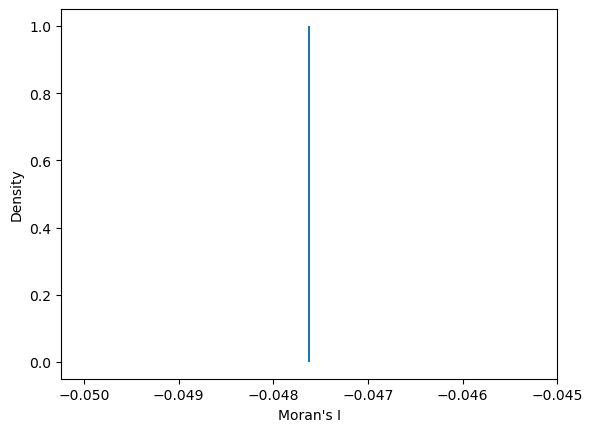

In [31]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [32]:
mi.p_sim

0.001

In [33]:
np.random.seed(12345)

In [34]:
wq.transform = 'r'
lag_pti = lp.weights.lag_spatial(wq, sun_am['pti'])

In [35]:
pti = sun_am['pti']
b, a = np.polyfit(pti, lag_pti, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(pti, lag_pti, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(pti.mean(), lag_pti.min(), lag_pti.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_pti.mean(), pti.min(), pti.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(pti, a + b*pti, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of PTI')
plt.xlabel('PTI')
plt.show()

LinAlgError: SVD did not converge in Linear Least Squares